<a href="https://colab.research.google.com/github/jiansim03/AIFFEL_ONLINE_QUEST/blob/main/Quest08/news_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 뉴스기사 요약해보기
---
- 추상적 요약과 추출적 요약 모두 진행

In [1]:
pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=d014c0624e538c52c9cc6cab2c69eaac198a93b985643e3fa1ebd8d5c7270631
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [2]:
# 주요 라이브러리 버전 확인
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow
import summa
import pandas


print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.8.1
2.13.0
1.5.3
1.2.0


In [3]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

## Step 1. 데이터 수집하기
---
https://github.com/sunnysai12345/News_Summary
뉴스 기사 데이터(news_summary_more.csv) 사용

In [4]:
# 뉴스 기사 데이터 데이터 다운로드
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", \
                           filename="news_summary_more.csv") # 해당 링크의 파일 다운받아 지정한 파일네임으로 저장
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1') # csv > 데이터프레임

In [5]:
data.sample(10)# 데이터프레임에서 무작위로 10개 행 샘플링

,headlines,text
12198,I am safe: YSR Congress Chief Jagan Mohan afte...,After a man attacked him with a knife at Vizag...
62655,India's development my sole life mission: PM Modi,PM Narendra Modi on Saturday promised to under...
19201,India beat Pak to clinch record 15th Asiad med...,The Indian men's hockey team defeated eight-ti...
84098,Youths fire toy guns at Thai King in Germany,Two youths shot at Thailand's King Maha Vajira...
63795,Study reveals 'GPS' tool used by Portuguese to...,UK-based researchers have revealed details of ...
60314,Documents reveal details of US-Mexico border wall,"Documents, obtained under US Freedom of Inform..."
60687,500 died navigating Bengaluru's roads this yea...,Nearly 500 people have died navigating Bengalu...
88088,Madonna's adopted son training with Portugal f...,Singer Madonna's adopted son David Banda train...
71135,Genetic discovery explains skin-blistering 'Va...,US-based researchers have discovered a genetic...
11302,"If an inquiry starts on Rafale, PM Modi won't ...",Calling Rafale deal a 'PM Narendra Modi-Anil A...


In [6]:
print("데이터 개수", len(data))
print("데이터 정보", data.info())

데이터 개수 98401
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
데이터 정보 None


- `text`와 `headlines`, 두가지 열로 구성
- 추상적요약 시 text를 본문, headlindes를 이미 요약된 데이터로 삼아 모델 학습.
- 추출적요약의 경우 오직 text열만을 사용

## Step 2. 데이터 전처리하기 (추상적 요약)
---
- 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해본다.
- 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해본다.

### (1) 중복샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('headline열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headline열에서 중복을 배제한 유일한 샘플의 수 : 98280
text열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [8]:
# 'Text' 열에 대해서단 중복을 제거해주자 (summary는 이미 요약된 상태이므로 중복 제거 X)
data.drop_duplicates(subset=['text'], inplace=True)
print('중복 제거 후 전체 샘플 수: ', len(data))

중복 제거 후 전체 샘플 수:  98360


In [9]:
# Null 값 처리
data.isnull().sum() # Null 값이 없으므로 처리해줄 사항이 없음

headlines    0
text         0
dtype: int64

### (2) 텍스트 정규화와 불용어 제거
- 텍스트 정규화 : 같은의미임에도 다른의미로 쓰이는 단어들을 같은 표현들로 통일시켜준다. headline, text에 대해 수행한다
(정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
- 불용어제거 : 텍스트에 자주 등장하다 자연어 처리시 실질적으로 도움이 되지 않는 단어. text에 대해서만 수행한다

In [10]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어처리 : NLTK에서 제공하는 불용어 리스트 참조해 불용어 제거
nltk.download('stopwords') # 불용어 사전 다운로드
from nltk.corpus import stopwords

print('불용어 개수:', len(stopwords.words('english'))) # NLTK에서 제공하는 불용어 개수
print(stopwords.words('english')) # NLTK의 불용어 목록

불용어 개수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# 불용어 제거, 대문자>소문자, html태그 제거, 특수문자 제거 등의 처리 수행
# 불용어 제거는 Text전처리에서만 호출, Summary에서는 호출 X (요약 결과문이 자연스러운 문장 되기 위해)

# 데이터 전처리 함수

def preprocess_sentece(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        # 불용어가 아니면서, 글자가 1개 이상인 단어들로만 sentence를 재구성
             tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

    # 불용어 미제거 (Summary)
    else:
        # 문장을 모두 쪼개어 글자수가 1인 단어만 제거하고 다시 문장으로 재구성
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 위에서 만든 함수에 문장을 적용해 잘 작동하는지 테스트

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print('text: ', preprocess_sentece(temp_text))
print('summary: ', preprocess_sentece(temp_summary, False)) # 불용어 제거 X

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary:  great way to start the day


In [14]:
# 전체 text 컬럼 데이터에 대한 전처리

clean_text = []
clean_text = data['text'].apply(preprocess_sentece).tolist() # 'text'열에 대해 전처리 수행 후 리스트에 저장

# 전처리 후 출력
print('\'text\'열 전처리후 결과:', clean_text[:5]) # 0~5개까지 출력해본다

'text'열 전처리후 결과: ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insu

In [15]:
# headline 컬럼에 대한 전처리. 불용어 처리 = False

clean_headlines = []

clean_headlines = data['headlines'].apply(preprocess_sentece, remove_stopwords=False).tolist()

print('\'headlines\' 열의 전처리 후 결과', clean_headlines[:5])

<ipython-input-12-b7ac0e96c474>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거


'headlines' 열의 전처리 후 결과 ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
# 텍스트 정제 후 다시 한 번 빈 샘플이 생겼는지 확인해보자

# 리스트 내 정제된 데이터들을 데이터프레임에 재저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값('')을 Null값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum() # null 값은 없음

headlines    0
text         0
dtype: int64

### 데이터 전처리하기 (2) 훈련 데이터와 테스트 데이터 나누기

In [18]:
# 훈련에 사용할 샘플의 최대길이 정하자
# text, headline의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']] # 'Text' 컬럼의 각 행에 대해 단어수를 계산해 'text_len' 배열의 해당하는 인덱스에 저장
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트 최소 길이:{}'.format(np.min(text_len)))
print('텍스트 최대 길이:{}'.format(np.max(text_len)))
print('텍스트 평균 길이:{}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이:{}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이:{}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이:{}'.format(np.mean(headlines_len)))

텍스트 최소 길이:1
텍스트 최대 길이:60
텍스트 평균 길이:35.09968483123221
헤드라인의 최소 길이:1
헤드라인의 최대 길이:16
헤드라인의 평균 길이:9.299532330215534


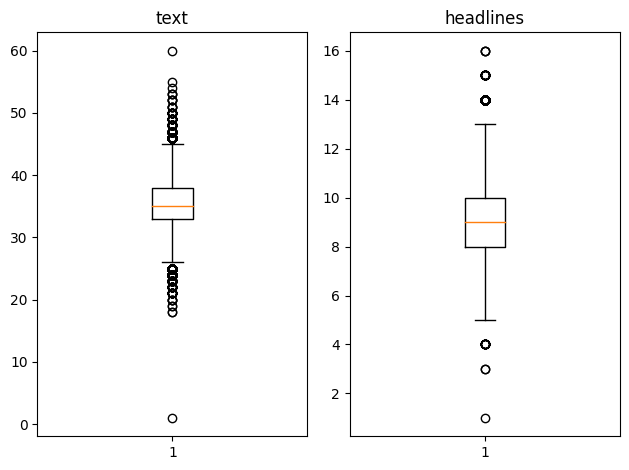

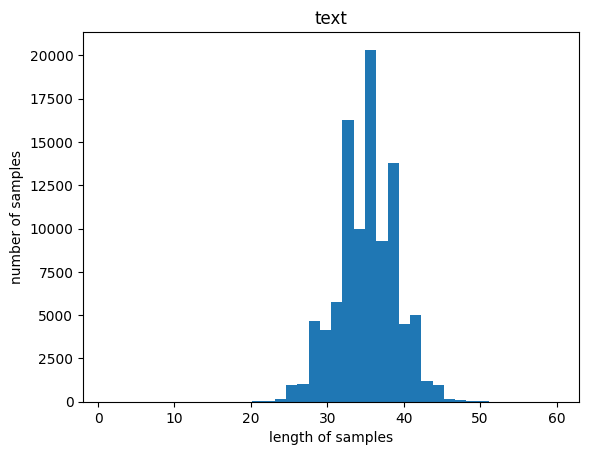

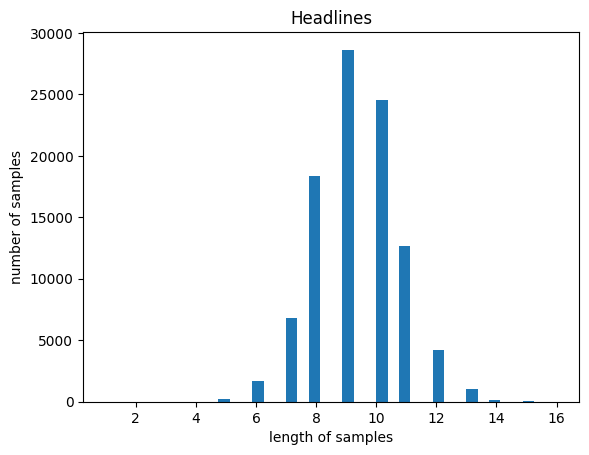

In [19]:
# 박스그림 그리기
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

# 'Text'컬럼 내 문장의 단어 개수 분포
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 'Headlines'컬럼 내 문장의 단어 개수 분포
plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# text의 최대길이와 headline의 적절한 최대길이&최소길이 임의로 설정.
# 이 길이보다 길거나 짧으면 제외하는 방식으로 데이터 정제한다
text_max_len = 40
headlines_max_len = 11

text_min_len = 30
headlines_min_len = 8

In [21]:
# 임의로 정한 최대&최소 길이가 몇%의 샘플까지 포함하는지 볼 수 있다.
def in_threshold_len(max_len, min_len,nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len and len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이상 %s이하인 샘플의 비율: %s'%(min_len ,max_len, (cnt/len(nested_list))))

in_threshold_len(text_max_len, text_min_len ,data['text'])
in_threshold_len(headlines_max_len, headlines_min_len,data['headlines'])

전체 샘플 중 길이가 30 이상 40이하인 샘플의 비율: 0.8539955266368442
전체 샘플 중 길이가 8 이상 11이하인 샘플의 비율: 0.8562728751525011


In [23]:
# text의 문장수 범위를 충족하는 문장들만으로 데이터프레임 재구성
filtered_data = data[(data['text'].apply(lambda x: len(x.split())) >= text_min_len) & (data['text'].apply(lambda x: len(x.split())) <= text_max_len)]
# headlines의 문장수 범위를 충족하는 문장들만으로 데이터프레임 재구성
filtered_data = filtered_data[(data['headlines'].apply(lambda x: len(x.split())) >= headlines_min_len) & (data['headlines'].apply(lambda x: len(x.split())) <= headlines_max_len)]

<ipython-input-23-f565ae531180>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[(data['headlines'].apply(lambda x: len(x.split())) >= headlines_min_len) & (data['headlines'].apply(lambda x: len(x.split())) <= headlines_max_len)]


In [24]:
print(len(data), len(filtered_data))
print(filtered_data.shape)

98360 72036
(72036, 2)


### 시작 토큰과 종료 토큰 추가하기
headlines에 시작토큰과 종료토큰 추가한다

In [25]:
filtered_data['decoder_input'] = filtered_data['headlines'].apply(lambda x : 'sostoken ' + x)
filtered_data['decoder_target'] = filtered_data['headlines'].apply(lambda x : x + ' eostoken')

# 토큰 열이 잘 만들어졌는지 확인
filtered_data.head()
# filtered_data['decoder_target'][0]

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [26]:
# 인코더의 입력, 디코더의 입력과 레이블일 다시 Numpy 타입으로 저장
encoder_input = np.array(filtered_data['text'])
decoder_input = np.array(filtered_data['decoder_input'])
decoder_target = np.array(filtered_data['decoder_target'])

In [27]:
len(encoder_input), len(decoder_input), len(decoder_target)

(72036, 72036, 72036)

In [28]:
# 훈련데이터와 테스트데이터 분리
# encoder_input과 크기와 형태가 같은, 순서가 섞인 시퀀스 만든다

indices = np.arange(encoder_input.shape[0]) # encoder_input 개수만큼의 일련의 정수로 채워진 리스트 생성
np.random.shuffle(indices) # 리스트 원소들 섞는다
print(indices)

[ 4823 66115 27421 ... 26476 31267 24734]


In [29]:
# 위 시퀀스 이용해 다시 데이터 샘플 순서를 정의해 샘플 섞어준다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [30]:
# 섞인 데이터를 8:2비율로 훈련/테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수:', n_of_val)

테스트 데이터의 수: 14407


In [31]:
# n_of_val 비율만큼 데이터를 분리한다
encoder_input_train = encoder_input[:-n_of_val] # 0~80%
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:] # 80~100%
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수:', len(encoder_input_train))
print('훈련 레이블의 개수:', len(decoder_input_train))
print('훈련 데이터의 개수:', len(encoder_input_test))
print('훈련 레이블의 개수:', len(decoder_input_test))

훈련 데이터의 개수: 57629
훈련 레이블의 개수: 57629
훈련 데이터의 개수: 14407
훈련 레이블의 개수: 14407


### 데이터 전처리하기 (3) 정수 인코딩
기계가 텍스트를 숫자로 처리할수 있도록 데이터의 단어들을 모두 정수로 바꿔준다

In [32]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어집합 생성 & 각 단어 고유 정수 부여

In [33]:
src_tokenizer.word_counts.items() # 생성된 단어집합 확인

odict_items([('third', 1311), ('day', 3140), ('first', 6776), ('test', 2381), ('adelaide', 48), ('oval', 36), ('rishabh', 71), ('pant', 130), ('completed', 358), ('six', 1703), ('catches', 54), ('australia', 1410), ('innings', 603), ('equal', 113), ('ms', 385), ('dhoni', 689), ('record', 1306), ('taken', 1340), ('announced', 2144), ('retirement', 149), ('cricket', 1959), ('held', 1177), ('new', 4270), ('zealand', 500), ('wellington', 15), ('kolkata', 427), ('police', 6834), ('directed', 1167), ('bar', 219), ('owners', 159), ('city', 1337), ('get', 1733), ('potential', 246), ('drunk', 182), ('drivers', 283), ('tested', 133), ('leave', 604), ('premises', 193), ('keep', 522), ('pool', 105), ('spare', 48), ('drive', 287), ('home', 1577), ('customers', 479), ('found', 2378), ('unsuitable', 2), ('driving', 479), ('also', 8239), ('asked', 2519), ('take', 1941), ('assistance', 154), ('cab', 159), ('aggregators', 16), ('like', 3165), ('ola', 182), ('uber', 734), ('putting', 129), ('organised', 

In [34]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


# 등장빈호가7회 미만인 단어들은 단어집합에서 68% 가량 차지
# 하지만 실제로 훈련데이터에서 차지하는 비중은 4.16%
# 이 단어들은 모두 제거하도록 한다.


단어 집합(vocabulary)의 크기 : 60139
등장 빈도가 6번 이하인 희귀 단어의 수: 41158
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18981
단어 집합에서 희귀 단어의 비율: 68.43811835913468
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.150430157250357


In [35]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어집합의 크기를 scr_vocab 만큼 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [36]:
# text_to_sequence():파라미터로 받은 문장들을, 단어집합에 해당하는 정수로 인코딩해준다
# 단어집합의 크기를 src_vocab만큼 제한했으므로 19000이 넘는 숫자들은 인코딩 후 존재하지 않는다

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train) # 샘플 출력해보자

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
# headlines에도 동일 작업 수행한다
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼 비중 차지하는지 확인해보자
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어 집합 내 단어의 총 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등장빈도 5회 이하인 단어 : 66.5%
# 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중 : 5.64%

단어 집합(vocabulary)의 크기 : 26515
등장 빈도가 5번 이하인 희귀 단어의 수: 17660
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8855
단어 집합에서 희귀 단어의 비율: 66.6038091646238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.661122584575424


In [39]:
tar_vocab = 17000 # threshole값 설정해 실제 사용 비중이 낮은 희귀단어들을 걸러준다
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train) # 단어집합 생성 & 정수 부여
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5]) # 정수형 시퀀스로 잘 변환된 것을 확인할 수 있다
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4072, 1530, 1339, 2605, 94, 895, 3, 1231, 972, 225, 111], [1, 7426, 1471, 3, 1358, 761, 1637, 172, 4, 851, 1472], [1, 29, 731, 3, 914, 263, 13427, 3, 438], [1, 837, 9880, 1182, 3, 185, 1034, 3090, 906, 973, 4, 14], [1, 3091, 115, 3, 72, 39, 1387, 9881, 13, 21]]
target
decoder  [[4072, 1530, 1339, 2605, 94, 895, 3, 1231, 972, 225, 111, 2], [7426, 1471, 3, 1358, 761, 1637, 172, 4, 851, 1472, 2], [29, 731, 3, 914, 263, 13427, 3, 438, 2], [837, 9880, 1182, 3, 185, 1034, 3090, 906, 973, 4, 14, 2], [3091, 115, 3, 72, 39, 1387, 9881, 13, 21, 2]]


- 현재 decoder_input_train 과 decoder_target_train 에는 더이상 2000이 넘는 숫자들은 존재 X
- 패딩 작업으로 넘어가기 전에 빈도수 낮은 단어들로만 구성되어있었던 샘플들이 다 잘려나가 비어 Null값이 되지 않았는지 확인한다
- 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아온다
- 이때 decoder_input에는 sostoken, decoder_target에는 eostoken이 추가된 상태
- 두 토큰은 모든 샘플에 등장하므로 빈도수가 매우 높음. 단어 집합 제한에서도 삭제 X
- 그러므로 길이가 0이 된 요약문 실제 길이는 1로 나옴.
- 훈련/테스트 데이터에 대해 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 저장해본다. 해당샘플들은 삭제될 예정이다

In [40]:
drop_train = [ index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1 ]
drop_test = [ index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1 ]

print('삭제할 훈련 데이터의 개수:', len(drop_train))
print('삭제할 테스트 데이터의 개수:', len(drop_test))

# 인덱스가 위 drop_train, drop_test에 해당하지 않는 원소들만으로 다시 배열을 구성한다
encoder_input_train = [ sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train ]
decoder_input_train = [ sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train ]
decoder_target_train = [ sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train ]

encoder_input_test = [ sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_test ]
decoder_input_test = [ sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_test ]
decoder_target_test = [ sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_test ]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 훈련 데이터와 테스트 데이터 모두 일정량 샘플들이 제거된 것을 확인할 수 있다

삭제할 훈련 데이터의 개수: 0
삭제할 테스트 데이터의 개수: 0
훈련 데이터의 개수 : 57629
훈련 레이블의 개수 : 57629
테스트 데이터의 개수 : 57629
테스트 레이블의 개수 : 57629


### 패딩하기
- **패딩작업** : 서로 다른 길이의 샘플들을 병렬처리하기위해 같은 길이로 맞춰주는 작업
- `pad_sequence()` 메서드를 이용하면 첫번째 인자의 시퀀스에 두번째 길이가 되도록 패딩을 넣어줄 수 있다.
- 패딩 길이는 아까 정해주었던 최대 길이로 한다.
- 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 맞춰준다

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있음.
- 어텐션 메커니즘을 사용한 seq2seq를 설계해본다


In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  # encoder_output1은 LSTM 1의 출력

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)  # encoder_output2는 LSTM 2의 출력

In [43]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2432000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

#### 어텐션 메커니즘

In [45]:
# 인코더의 hidden state들과 디코더의 hidden state들을 어텐션함수의 입력으로 사용하고
# 어텐션함수가 리턴한 값을 예측시에 디코더의 hidden state와 함께 활용

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output2])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 40, 128)              2432000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 40, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [46]:
# 모델학습
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
226/226 [==============================] - 66s 234ms/step - loss: 6.9306 - val_loss: 6.6555
Epoch 2/50
226/226 [==============================] - 38s 170ms/step - loss: 6.5217 - val_loss: 6.5043
Epoch 3/50
226/226 [==============================] - 35s 156ms/step - loss: 6.4549 - val_loss: 6.4385
Epoch 4/50
226/226 [==============================] - 36s 161ms/step - loss: 6.3972 - val_loss: 6.3633
Epoch 5/50
226/226 [==============================] - 35s 153ms/step - loss: 6.3215 - val_loss: 6.2543
Epoch 6/50
226/226 [==============================] - 34s 149ms/step - loss: 6.1964 - val_loss: 6.1547
Epoch 7/50
226/226 [==============================] - 33s 147ms/step - loss: 6.0897 - val_loss: 6.0552
Epoch 8/50
226/226 [==============================] - 34s 151ms/step - loss: 6.0090 - val_loss: 6.0024
Epoch 9/50
226/226 [==============================] - 33s 145ms/step - loss: 5.9383 - val_loss: 5.9102
Epoch 10/50
226/226 [==============================] - 33s 147ms/step - l

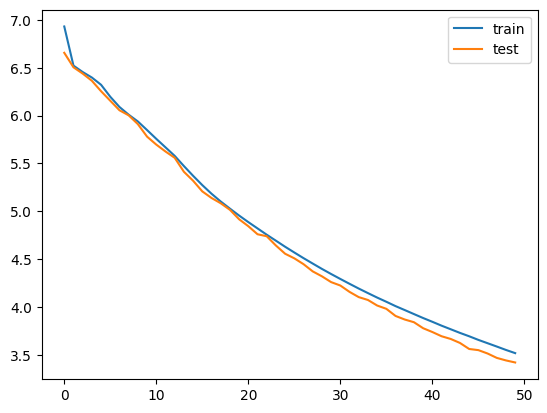

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 본다.


In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output2, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 한다.
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
### 모델 테스트하기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken']):  # 시작 토큰(sostoken)을 만나면 종료
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [53]:
print(decoder_input_test[0])
print(decoder_input_test[1])
print(decoder_input_test[2])
print(decoder_input_test[2])
print(tar_index_to_word[3])

[4072 1530 1339 2605   94  895    3 1231  972  225  111]
[   1 7426 1471    3 1358  761 1637  172    4  851 1472]
[    1    29   731     3   914   263 13427     3   438     0     0]
[    1    29   731     3   914   263 13427     3   438     0     0]
to


In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : iceland become smallest country ever qualify final stage fifa world cup topping qualifying group island nation population registered football players last year iceland played first major tournament uefa european championship team defeated england reached quarter final stage 
실제 요약 : iceland becomes smallest nation ever to enter fifa world cup 
1/1 [==============================] - 0s 27ms/step
예측 요약 :  world cup win world cup final final in fifa world


원문 : canadian police tweeted picture saying lettuce work together large truck containing lettuce worth stolen police also asked public calm incident variety lettuce following post person tweeted lookout 
실제 요약 : lettuce work together police on lakh lettuce theft 
1/1 [==============================] - 0s 23ms/step
예측 요약 :  us police uses drunk drunk car in bengaluru


원문 : twitter handle prime minister office wednesday shared video pm narendra modi speech parliament along statement proposed healthcare scheme however typo caption m

## Step 5. Summa을 이용해서 추출적 요약해보기
---
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다
- 추출적 요약은 추상적 요약에 비해 난이도가 낮고, 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다
- Summa의 summarize를 사용하여 추출적 요약을 한다


In [55]:
from summa.summarizer import summarize

In [56]:
# 데이터 다운로드
import requests
from summa.summarizer import summarize

In [57]:
# 매트릭스 시놉시스 다운받아 변수에 저장
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [58]:
# 비율을 적게 주어 요약문으로 선택되는 문장의 개수를 줄여보자(원문의 0.005%)

print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [59]:
# 리스트로 출력결과를 받으려면 split=True
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [60]:
# 단어의 수로 요약문의 크기를 조절할 수 있다
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
